# Explainable AI
this script includes the scaffold needed to test out explainable AI for the melanoma classification project. access to the following data is given
- a ML model
- input shape expected by that model
- a single image and a corresponding prediction

## Import utils script setup

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Getting the model

#### Load model into memory

In [5]:
from tensorflow.keras.models import load_model

model_path = "NNM_Model/sequential_results/SequentialNNM_Gridsearch-allData-031122-100/100percent/model_04112022145033.h5"
model = load_model(model_path)

ImportError: cannot import name 'dtensor' from 'tensorflow.compat.v2.experimental' (C:\Users\rgvil\anaconda3\envs\tf2\lib\site-packages\tensorflow\_api\v2\compat\v2\experimental\__init__.py)

#### Investigate expected shape

In [6]:
from math import sqrt

input_shape = model.get_config()["layers"][0]["config"]["batch_input_shape"]
expect_flattened_input = len(input_shape) == 2
img_pixel = int(sqrt(input_shape[1]/3) if expect_flattened_input else sqrt(input_shape[1]/3))

NameError: name 'model' is not defined

In [ ]:
are_flat = "are" if expect_flattened_input else "are not"
print(f"the model expects images with size {img_pixel}*{img_pixel} which {are_flat} flattened out")

## Load images

#### Config on where to find the data

In [5]:
base_path = "data" 
downsampled_data = False
partition = "test"
num_images = 2

In [6]:
img_folder = base_path + "/" + partition + ("_downsampled" if downsampled_data else "")
groundtruth_file = base_path + "/ISIC_2020_2019_" + partition + ("_downsampled" if downsampled_data else "") + ".csv" 

#### Getting image(s)

In [7]:
from utilities import get_img_paths, load_data, split_predictors_target

img_paths = get_img_paths(img_folder, num_images) 
df = load_data(img_paths, groundtruth_file, img_pixel=img_pixel)
X, y = split_predictors_target(df) 

if not expect_flattened_input:
    X = unflatten_images_df(X, img_pixel=img_pixel)

# Hi Renée
at this point, 
- X includes a list of images which may or may not be flat depending on what the model expects. 
- y includes the correct labels
- model includes the loaded ML model which should be used to make the predicitons.

You can adjust the num of images display with num_images and the model used in model_path. the other stuff should (hopefully) be automatically adjusted

## Predict and display images

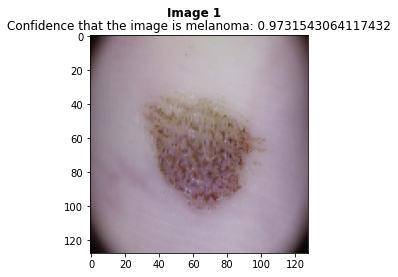

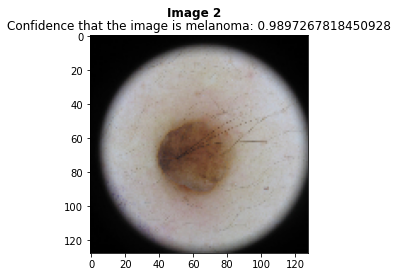

In [8]:
import matplotlib.pyplot as plt
depth = 3

# predict images
y_pred = model.predict(X)

i = 0
for img_name, img in X.iterrows():
    # output prediction
    title = f"Image {i+1}"
    prediction = f"Confidence that the image is melanoma: {y_pred[i][0]}"
    i+=1
        
    # get image in correct format
    img_to_display = img.to_numpy()
    if expect_flattened_input:
        img_to_display = img_to_display.reshape(img_pixel,img_pixel,depth) # unflatten the image
    
    # display image
    plt.figure()
    plt.imshow(img_to_display)
    plt.title(prediction)
    plt.suptitle(title, fontweight ="bold")

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn tensorflow lime scikit-image

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

print(f" Version of tensorflow used: {tf.__version__}")

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
exp = explainer.explain_instance(normalized_img[0], 
                                 model.predict, 
                                 top_labels=5, #might not need
                                 hide_color=0, 
                                 num_samples=1000)

In [ ]:
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

In [1]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)
#highlight the contour of the superpixel and include the background

NameError: name 'generate_prediction_sample' is not defined

In [ ]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)
#highlight the positive super-pixels and negative superpixels

In [ ]:
#Heatmap
#show how important each super-pixel is to get more granular explaianbility.
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])